In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import scipy.io as io
import gym
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from ns3gym import ns3env

/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sheila/

Observation space:  Box(0, 100, (5,), uint64) uint64
Action space:  Box(0, 100, (5,), uint64) uint64
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
episode: 0/50, time: 99, rew: 0.0, eps: 0.91
episode: 1/50, time: 99, rew: 167.0, eps: 0.82
episode: 2/50, time: 99, rew: 122.0, eps: 0.74
episode: 3/50, time: 99, rew: 140.0, eps: 0.67
episode: 4/50, time: 99, rew: 95.0, eps: 0.61
episode: 5/50, time: 99, rew: 169.0, eps: 0.55
episode: 6/50, time: 99, rew: 134.0, eps: 0.5
episode: 7/50, time: 99, rew: 166.0, eps: 0.45
episode: 8/50, time: 99, rew: 142.0, eps: 0.41
episode: 9/50, time: 99, rew: 147.0, eps: 0.37
episode: 10/50, time: 99, rew: 168.0, eps: 0.34
episode: 11/50, time: 99, rew: 168.0, eps: 0.3
episode: 12/50, time: 99, rew: 126.0, eps: 0.28
episode: 13/50, time: 99, rew: 140.0, eps: 0.25
episode: 14/50, time: 99, rew: 154.0, eps: 0.23
episode: 15/50, time: 99, rew: 172.0, eps: 0.2
episode: 16/50, time: 99, rew

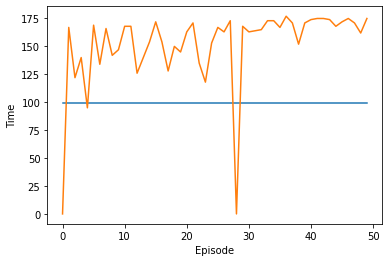

Save curves to MATLAB file


In [2]:
class DqnAgent(object):
    """docstring for DqnAgent"""
    def __init__(self, inNum, outNum):
        super(DqnAgent, self).__init__()
        self.model = keras.Sequential()
        self.model.add(keras.layers.Dense(inNum, input_shape=(inNum,), activation='relu'))
        self.model.add(keras.layers.Dense(outNum, activation='softmax'))
        self.model.compile(optimizer=tf.train.AdamOptimizer(0.001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

    def get_action(self, state):
        return np.argmax(self.model.predict(state)[0])

    def predict(self, next_state):
        return self.model.predict(next_state)[0]

    def fit(self, state, target, action):
        target_f = self.model.predict(state)
        target_f[0][action] = target
        self.model.fit(state, target_f, epochs=1, verbose=0)


# Environment initialization
port = 5562
simTime = 10 # seconds
startSim = True
stepTime = 0.05 # seconds
seed = 132
simArgs = {"--simTime": simTime,
           "--testArg": 123,
           "--nodeNum": 5,
           "--distance": 500}
debug = False

env = ns3env.Ns3Env(port=port, stepTime=stepTime, startSim=startSim, simSeed=seed, simArgs=simArgs, debug=debug)
#env = gym.make('ns3-v0')


ob_space = env.observation_space
ac_space = env.action_space
print("Observation space: ", ob_space,  ob_space.dtype)
print("Action space: ", ac_space, ac_space.dtype)
s_size = ob_space.shape[0]
a_size = ac_space.shape[0]

inputQueues = 1
cwSize = 100

agent0 = DqnAgent(inputQueues, cwSize)
agent1 = DqnAgent(inputQueues, cwSize)
agent2 = DqnAgent(inputQueues, cwSize)
agent3 = DqnAgent(inputQueues, cwSize)

total_episodes = 50
max_env_steps = 100
env._max_episode_steps = max_env_steps

epsilon = 1.0               # exploration rate
epsilon_min = 0.01
epsilon_decay = 0.999

time_history = []
rew_history = []

for e in range(total_episodes):

    state = env.reset()
    state = np.reshape(state, [1, s_size])
    rewardsum = 0
    for time in range(max_env_steps):

        # Choose action
        if np.random.rand(1) < epsilon:
            action0 = np.random.randint(cwSize)
            action1 = np.random.randint(cwSize)
            action2 = np.random.randint(cwSize)
            action3 = np.random.randint(cwSize)
        else:
            action0 = agent0.get_action(state[:,0]-state[:,1])
            action1 = agent1.get_action(state[:,1]-state[:,2])
            action2 = agent2.get_action(state[:,2]-state[:,3])
            action3 = agent3.get_action(state[:,3]-state[:,4])

        # Step
        actionVec = [action0, action1, action2, action3, 100]
        next_state, reward, done, _ = env.step(actionVec)

        if done:
            print("episode: {}/{}, time: {}, rew: {}, eps: {:.2}"
                  .format(e, total_episodes, time, rewardsum, epsilon))
            break

        next_state = np.reshape(next_state, [1, s_size])

        # Train
        target0 = reward
        target1 = reward
        target2 = reward
        target3 = reward

        if not done:
            target0 = reward + 0.95 * np.amax(agent0.predict(next_state[:,0]-next_state[:,1]))
            target1 = reward + 0.95 * np.amax(agent1.predict(next_state[:,1]-next_state[:,2]))
            target2 = reward + 0.95 * np.amax(agent2.predict(next_state[:,2]-next_state[:,3]))
            target3 = reward + 0.95 * np.amax(agent3.predict(next_state[:,3]-next_state[:,4]))

        agent0.fit(state[:,0]-state[:,1], target0, action0)
        agent1.fit(state[:,1]-state[:,2], target1, action1)
        agent2.fit(state[:,2]-state[:,3], target2, action2)
        agent3.fit(state[:,3]-state[:,4], target3, action3)

        state = next_state
        rewardsum += reward
        if epsilon > epsilon_min: epsilon *= epsilon_decay
        
    time_history.append(time)
    rew_history.append(rewardsum)

#for n in range(2 ** s_size):
#    state = [n >> i & 1 for i in range(0, 2)]
#    state = np.reshape(state, [1, s_size])
#    print("state " + str(state) 
#        + " -> prediction " + str(model.predict(state)[0])
#        )

#print(model.get_config())
#print(model.to_json())
#print(model.get_weights())

plt.plot(range(len(time_history)), time_history)
plt.plot(range(len(rew_history)), rew_history)
plt.xlabel('Episode')
plt.ylabel('Time')
plt.show()


curve0 = np.zeros(shape=(101))
curve1 = np.zeros(shape=(101))
curve2 = np.zeros(shape=(101))
curve3 = np.zeros(shape=(101))

for i in range(101):
    state = np.array([i])
    state = np.reshape(state, [1, 1])

    curve0[i] = agent0.get_action(state)
    curve1[i] = agent1.get_action(state)
    curve2[i] = agent2.get_action(state)
    curve3[i] = agent3.get_action(state)
        
print("Save curves to MATLAB file")
io.savemat("curves_1d.mat", {
                '0':curve0,
                '1':curve1,
                '2':curve2,
                '3':curve3,
               }
          )